In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import chi2_contingency
import scipy.stats as stats
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram

### Post Feature Engineering Features (17)

| **Feature Type**                  | **Feature Name**                          | **Description**                                                                 |
|-----------------------------------|-------------------------------------------|---------------------------------------------------------------------------------|
| **Experience-Related Features (6)** | `overall_staff_service`                   | Reflects the quality of service provided by staff members.                      |
|                                   | `weighted_food_shopping_satisfaction_score` | Measures satisfaction with food and shopping options.                           |
|                                   | `weighted_amenities_satisfaction_score`    | Captures satisfaction with park amenities, like cleanliness and seating.        |
|                                   | `weighted_entry_experience_score`          | Reflects satisfaction with the entry process, including ticketing and queue times. |
|                                   | `attraction_overall_experience`            | Indicates the quality of the ride and attraction experiences.                   |
|                                   | `thrill_seeker_level`                      | Reflects guests' preference for thrill-based attractions, impacting their experience. |
| **Outcome-Related Features (3)**   | `overall_satisfaction`                    | Measures the guest’s overall satisfaction with their visit.                     |
|                                   | `total_spend`                              | Captures guest spending behavior, influenced by satisfaction and perceived value. |
|                                   | `return_likelihood`                        | Indicates likelihood of returning, representing long-term satisfaction and loyalty. |
| **Demographic-Related Features (4)** | `age_group`                               | Categorizes guests by age (Children, Young Adults, Middle-Aged Adults, Seniors). |
|                                   | `gender`                                   | Identifies gender of the guests (Female, Male).                                 |
|                                   | `occupation`                               | Describes guests' employment status (Employed, Student, Retired, Other).        |
|                                   | `visitor_profile`                          | Differentiates between local visitors and tourists (Singaporean, Tourist).      |
| **Behavioral-Related Features (4)** | `visitor_type`                            | Describes the nature of the visit (Solo, Family, Group).                        |
|                                   | `ticket_purchase_method`                   | Shows where tickets were purchased, indicating planning habits and marketing reach. |
|                                   | `ticket_type`                              | Type of ticket purchased (One-day regular, Express Pass, VIP Experience).       |
|                                   | `special_event_ticket`                     | Indicates whether a special event ticket was purchased, showing preference for exclusive experiences. |


## **Guest Segmentation Model:** Analyzing Revenue Potential, Behavior, Preferences, and Demographics

To develop a guest segmentation model, we analyzed clusters based on **revenue potential**, **demographic profiles**, and **behavioral preferences**. This approach helps identify unique needs, preferences, and pain points for each guest segment, enabling targeted strategies to enhance guest satisfaction and increase revenue.

### 1. Cluster 0: High Satisfaction, Thrill-Seeking Group Visitors
- **Demographics**: Predominantly **young adults**, **female**, **Singaporean** students.
- **Behavioral Profile**: Primarily **group visitors** who purchase **regular tickets** online via official and third-party channels, with moderate interest in special events.
- **Revenue Potential**: High return likelihood (0.78) and moderate total spend (0.65).
- **Needs & Preferences**:
  - Enjoy **thrill-based attractions** and social experiences suited for groups.
- **Pain Points**:
  - Minor improvements in **food and shopping experiences** could enhance overall satisfaction for this group.


### 2. Cluster 1: Low Satisfaction, Family-Oriented Tourists
- **Demographics**: Predominantly **family groups** with a mix of **children, middle-aged adults, and seniors**; entirely **male** and mostly **tourists**.
- **Behavioral Profile**: High proportion of **premium ticket holders** (Express Pass and VIP Experience) who purchase tickets at the entrance or through third-party vendors.
- **Revenue Potential**: Low return likelihood (0.50) and minimal total spend (0.05).
- **Needs & Preferences**:
  - Seeking **family-friendly amenities** and high-quality experiences aligned with premium ticket expectations.
- **Pain Points**:
  - Major issues across all experience aspects, especially in **amenities and staff service**. Focus on improving fundamental aspects of the guest experience to meet the expectations of premium ticket holders in this segment.

### 3. Cluster 2: Moderate to High Satisfaction, Mixed Young Adults
- **Demographics**: Predominantly **young adults** with a balanced gender distribution, mostly **Singaporeans** but some tourists.
- **Behavioral Profile**: Primarily **group visitors** with a mix of **family and solo** guests. Prefer regular tickets, with half interested in special events, and typically purchase from third-party vendors.
- **Revenue Potential**: Moderate return likelihood (0.69) with the highest total spend (0.73).
- **Needs & Preferences**:
  - Enjoy a balance of **thrill and non-thrill attractions** with an emphasis on convenience and accessibility.
- **Pain Points**:
  - Minor improvements in **food, shopping, and attraction experience** could lead to higher satisfaction, helping retain these high-spending visitors.
 
By tailoring offerings to each segment’s unique needs, preferences, and pain points, USS can enhance guest satisfaction, drive repeat visits, and maximize revenue potential.

In [2]:
survey_data = pd.read_csv('/Users/liyuan/DSA3101/Sub Group A Q2/survey_data_17features.csv')

Top satisfaction drivers for clustering: ['overall_satisfaction', 'overall_staff_service', 'weighted_food_shopping_satisfaction_score', 'weighted_amenities_satisfaction_score', 'weighted_entry_experience_score', 'attraction_overall_experience', 'thrill_seeker_level']


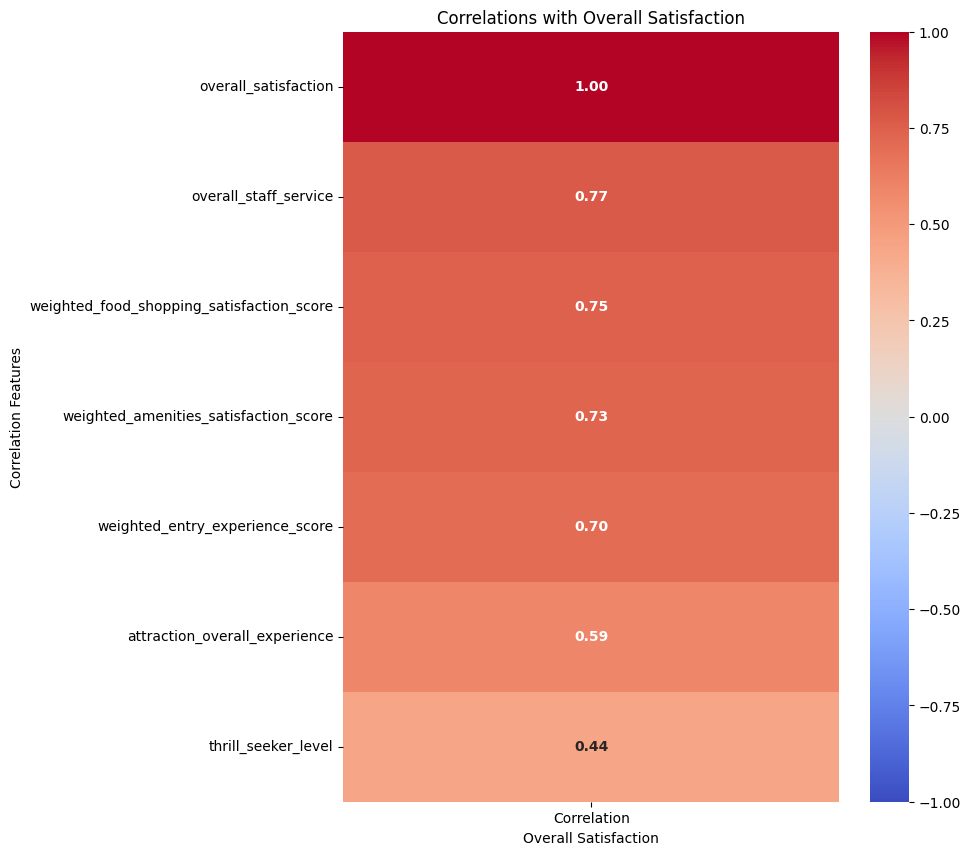

In [3]:
# Correlation Analysis
# Select only numeric features for correlation calculation
numeric_data = survey_data.select_dtypes(include=[np.number])

# Calculate correlations with overall_satisfaction
correlations = numeric_data.corr()
satisfaction_corr = correlations['overall_satisfaction'].abs().sort_values(ascending=False)

# Select features with high correlation to overall_satisfaction (threshold > 0.5)
top_features = satisfaction_corr[satisfaction_corr > 0.5].index.tolist()

# Add 'thrill_seeker_level' 
top_features.append('thrill_seeker_level')

print("Top satisfaction drivers for clustering:", top_features)

overall_satisfaction_corr_df = satisfaction_corr[top_features].to_frame(name='Correlation').sort_values(by="Correlation", ascending=False)

# Plot the correlation heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(
    overall_satisfaction_corr_df,
    annot=True,
    annot_kws={"weight": "bold"},  
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    fmt=".2f",
    cbar=True
)
plt.title("Correlations with Overall Satisfaction")
plt.xlabel("Overall Satisfaction")
plt.ylabel("Correlation Features")
plt.show()

In [4]:
# Define data for clustering based on top satisfaction drivers
clustering_data = survey_data[top_features]

## **1.1 K-Means Clustering with PCA**

### Clustering Approach and PCA Consistency

1. **Direct Clustering**: Applied K-means on top satisfaction drivers.
2. **Clustering with PCA**: Reduced data to 3 PCA components (retaining ~85% variance) and repeated K-means.

Both methods produced identical clusters, confirming that PCA retained the data's essential structure. Thus, we proceed with **1. Direct Clustering** for interpretability, using **PCA only for visualization**.

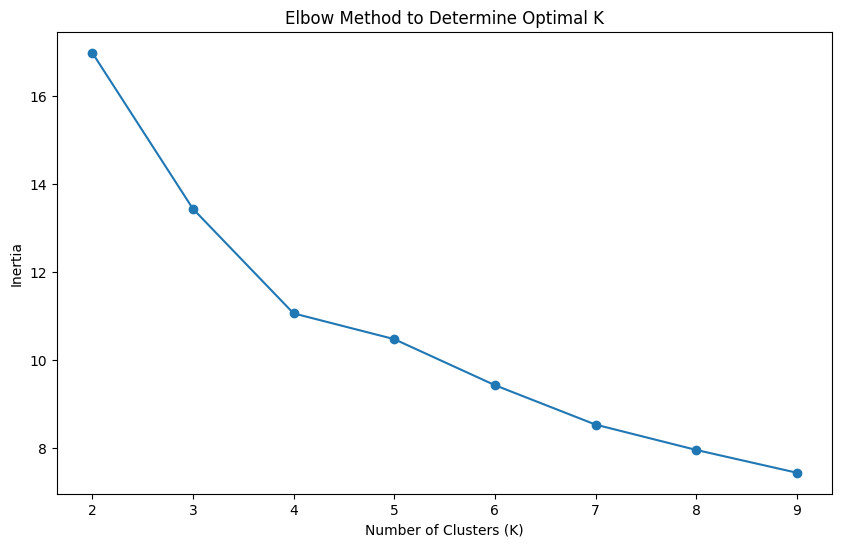

In [5]:
# Clustering using K-Means

# Determine optimal number of clusters using the Elbow Method
inertia = []
k_range = range(2, 10)  # Test from 2 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve to find the optimal K
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal K')
plt.show()

In [6]:
# Initialize lists to store results
silhouette_scores = []
cluster_options = [3, 4]  

for k in cluster_options:
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(clustering_data)
    
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(clustering_data, labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f'Silhouette Score for K={k}: {silhouette_avg}')

Silhouette Score for K=3: 0.3470049238829705
Silhouette Score for K=4: 0.2584490294947951


### Choosing the Optimal Number of Clusters (K)

The Elbow Method suggests a potential optimal K at both **K=3** and **K=4**, as both points show significant drops in inertia. To further refine our choice, we calculated the Silhouette Scores for these values:
- **Silhouette Score for K=3**: 0.347
- **Silhouette Score for K=4**: 0.258

Since **K=3** yields a higher Silhouette Score, indicating better-defined clusters, we finalized **K=3** as the optimal number of clusters.

In [7]:
# Apply K-Means with chosen K 
optimal_k = 3 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
survey_data['Cluster'] = kmeans.fit_predict(clustering_data)

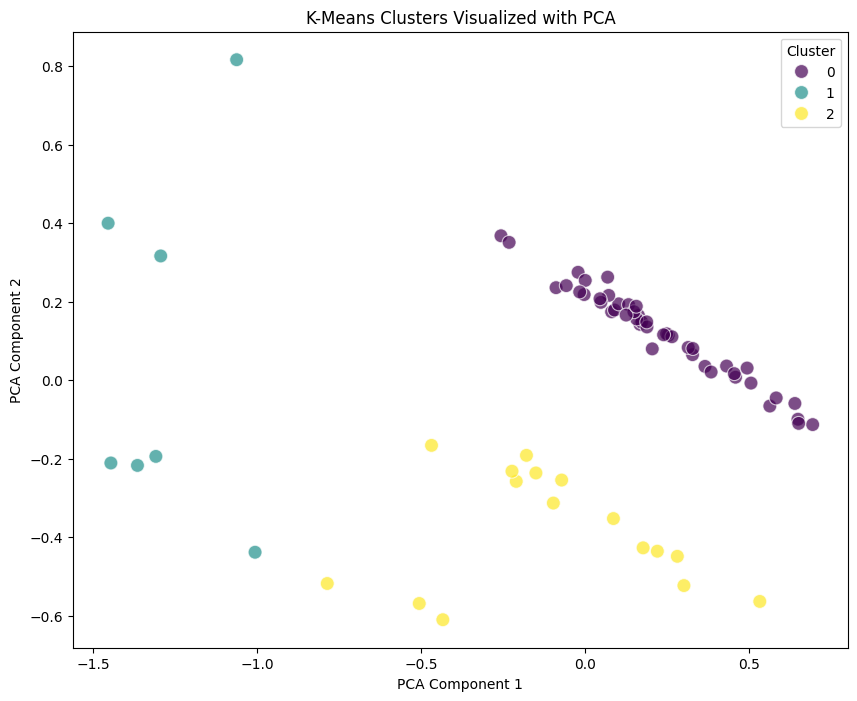

In [8]:
# Visualize Clusters using PCA

# Perform PCA to reduce dimensionality to 2 components for easier interpretation
pca = PCA(n_components=2)
pca_data = pca.fit_transform(clustering_data)

# Add the PCA components to the dataframe for plotting
survey_data['PCA1'] = pca_data[:, 0]
survey_data['PCA2'] = pca_data[:, 1]

# Plot the clusters in 2D space using the PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(data=survey_data, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('K-Means Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [25]:
# Analyze Cluster Characteristics
# Calculate the mean of each feature for each cluster to interpret the clusters
cluster_summary = survey_data.groupby('Cluster')[top_features + ['overall_satisfaction']].mean()
print("Cluster Characteristics:")
cluster_summary

Cluster Characteristics:


,overall_satisfaction,overall_staff_service,weighted_food_shopping_satisfaction_score,weighted_amenities_satisfaction_score,weighted_entry_experience_score,attraction_overall_experience,thrill_seeker_level,overall_satisfaction
Cluster,,,,,,,,
0,0.771739,0.766304,0.516894,0.706761,0.752573,0.744565,1.000000,0.771739
1,0.142857,0.178571,0.120478,0.084361,0.211254,0.321429,0.285714,0.142857
2,0.750000,0.750000,0.536063,0.630289,0.736057,0.703125,0.406250,0.750000


### **Cluster Summary Analysis and Pain Points**

### Cluster 0
- **Satisfaction**: High overall satisfaction (0.771) suggests that guests in this cluster are generally content with their experience.
- **Amenities and Entry Experience**: Scores for amenities (0.707) and entry experience (0.753) are relatively high, indicating positive feedback on these aspects.
- **Food & Shopping**: Slightly lower satisfaction with food and shopping (0.517) might indicate that this area could be further optimized to enhance the experience.
- **Thrill-Seeking**: Very high thrill-seeker level (1.0) suggests these guests highly value thrill-based attractions.
  
**Pain Points**:
- Potential to further improve food and shopping experiences, as it’s slightly lower compared to other satisfaction areas.

### Cluster 1
- **Satisfaction**: Very low overall satisfaction (0.143) indicates significant dissatisfaction in this cluster.
- **All Experiences**: Low scores across all experience-related metrics, especially amenities (0.084), entry experience (0.211), and staff service (0.179).
- **Thrill-Seeking**: Lower thrill-seeker level (0.286) indicates these guests may not be as interested in thrill-based attractions.
  
**Pain Points**:
  - **Amenities and Staff Service**: Major improvements needed in amenities and staff service to enhance guest satisfaction.
  - **Overall Experience**: This cluster’s low satisfaction across all metrics suggests an unmet expectation or a negative perception throughout their visit.


### Cluster 2
- **Satisfaction**: High overall satisfaction (0.75), similar to Cluster 0, indicating general contentment.
- **Entry Experience and Amenities**: High scores in entry experience (0.736) and amenities (0.63) suggest positive feedback in these areas.
- **Food & Shopping**: Slightly higher satisfaction (0.536) than Cluster 0, but still moderate.
- **Thrill-Seeking**: Moderate thrill-seeker level (0.406) indicates interest in thrill-based attractions but not as strongly as Cluster 0.
  
**Pain Points**:
  - **Food and Shopping**: Although better than Cluster 0, there’s still room to enhance food and shopping satisfaction.
  - **Attraction Experience**: With an attraction experience score of 0.703, there might be room to enhance the quality or variety of attractions to fully satisfy these guests.

### **1.2 Hierarchical Clustering**

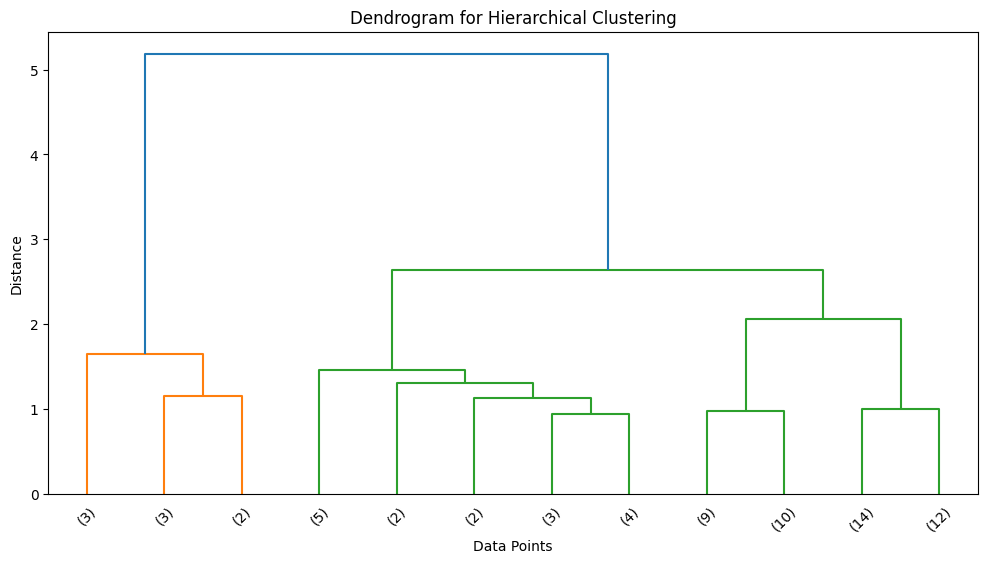

In [12]:
# Create the linkage matrix
linkage_matrix = linkage(clustering_data, method='ward')

# Plot dendrogram to visualize cluster distances
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=12, leaf_rotation=45, leaf_font_size=10)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

In [13]:
# Set a fixed number of clusters for hierarchical clustering
num_clusters = 3
hierarchical_labels_fixed = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')
survey_data['Hierarchical_Cluster_Fixed'] = hierarchical_labels_fixed

# Evaluate the hierarchical clustering with silhouette score
silhouette_fixed = silhouette_score(clustering_data, hierarchical_labels_fixed)

print(f"Hierarchical Clustering Silhouette Score (Number of Clusters = {num_clusters}): {silhouette_fixed}")

Hierarchical Clustering Silhouette Score (Number of Clusters = 3): 0.3236709036062365


#### **Justification for Setting the Number of Clusters to 3**

Based on visual inspection of the dendrogram, we selected **3 clusters** by cutting at a threshold that aligns with the main branching structure. This choice captures the most distinct groupings in the hierarchical structure.

To compare the clustering quality, we calculated the **Silhouette Score** for both K-means and hierarchical clustering using **3 clusters**:
- **K-means Silhouette Score (3 clusters):** 0.347
- **Hierarchical Clustering Silhouette Score (3 clusters):** 0.324

Since K-means yielded a higher Silhouette Score, it suggests that **K-means better captures the cluster structure in this dataset than hierarchical clustering** when using 3 clusters.


## **Validate Segments with Return Likelihood and Spend**

- **Overall Satisfaction** moderately correlates with **Return Likelihood** (0.43) and weakly with **Total Spend** (0.31).
- **Return Likelihood** and **Total Spend** have a moderate correlation (0.33), suggesting that guests likely to return also tend to spend more.


In [14]:
# Calculate correlations between overall satisfaction, return likelihood, and total spend
correlations = survey_data[['overall_satisfaction', 'return_likelihood', 'total_spend']].corr()
print("Correlation Matrix:")
print(correlations)

Correlation Matrix:
                      overall_satisfaction  return_likelihood  total_spend
overall_satisfaction              1.000000           0.430587     0.311509
return_likelihood                 0.430587           1.000000     0.330094
total_spend                       0.311509           0.330094     1.000000


### Statistical Validation
- **Return Likelihood**: ANOVA p-value of 0.07 (not significant), indicating that return likelihood differences across clusters are marginal.
- **Total Spend**: ANOVA p-value of 0.02 (significant), confirming that spending differs significantly across clusters.

In [15]:
# ANOVA Test
# Test for significant differences in return likelihood across clusters
anova_return = stats.f_oneway(
    survey_data[survey_data['Cluster'] == 0]['return_likelihood'],
    survey_data[survey_data['Cluster'] == 1]['return_likelihood'],
    survey_data[survey_data['Cluster'] == 2]['return_likelihood']
)
print("\nANOVA Test for Return Likelihood across Clusters:")
print(f"F-Statistic: {anova_return.statistic}, p-value: {anova_return.pvalue}")

# Test for significant differences in total spend across clusters
anova_spend = stats.f_oneway(
    survey_data[survey_data['Cluster'] == 0]['total_spend'],
    survey_data[survey_data['Cluster'] == 1]['total_spend'],
    survey_data[survey_data['Cluster'] == 2]['total_spend']
)
print("\nANOVA Test for Total Spend across Clusters:")
print(f"F-Statistic: {anova_spend.statistic}, p-value: {anova_spend.pvalue}")


ANOVA Test for Return Likelihood across Clusters:
F-Statistic: 2.772668112798264, p-value: 0.06978563211409097

ANOVA Test for Total Spend across Clusters:
F-Statistic: 4.134906199991002, p-value: 0.020330267100803424


In [17]:
# Calculate average return likelihood and total spend for each cluster
cluster_summary = survey_data.groupby('Cluster')[['return_likelihood', 'total_spend']].mean()
print("\nAverage Return Likelihood and Total Spend by Cluster (Ranked by descending revenue potential) :")
# Sort clusters based on descending average return likelihood and total spend
cluster_summary = cluster_summary.sort_values(by=['return_likelihood', 'total_spend'], ascending=False)
print(cluster_summary)


Average Return Likelihood and Total Spend by Cluster (Ranked by descending revenue potential) :
         return_likelihood  total_spend
Cluster                                
0                 0.782609     0.652174
2                 0.687500     0.729167
1                 0.500000     0.047619


### **Cluster Insights (Revenue Potential)**

#### Cluster 0 (High Satisfaction, Thrill Seekers)
- **Characteristics**: High satisfaction, high return likelihood (0.78), and moderate total spend (0.65).
- **Insights**: This is a high-value segment with strong loyalty and spending potential.

#### Cluster 1 (Low Satisfaction, Minimal Thrill Preference)
- **Characteristics**: Very low satisfaction, low return likelihood (0.50), and minimal spending (0.05).
- **Insights**: This is an at-risk segment with low satisfaction, low loyalty, low spending and minimal thrill preference.

#### Cluster 2 (Moderate to High Satisfaction, Moderate Thrill Seekers)
- **Characteristics**: High satisfaction, moderate return likelihood (0.69), and the highest total spend (0.73).
- **Insights**: Satisfied guests with balanced preferences (moderate thrill seekers) and high spending, indicating good revenue potential.

### Revenue Potential Ranking (Descending)

1. **Cluster 0**: High return likelihood (0.78) and spending (0.65)
2. **Cluster 2**: Moderate return likelihood (0.68) but highest spending (0.72)
3. **Cluster 1**: Low return likelihood (0.50) and spending (0.05)

## **Demographic Profiles of Each Cluster**

In [18]:
# Define demographic features
demographic_features = ['age_group', 'gender', 'occupation', 'visitor_profile']

### Statistical Validation¶

In [19]:
# Chi-Square Test for Association with Clusters
print("\nChi-Square Test Results:")
for feature in demographic_features:
    contingency_table = pd.crosstab(survey_data['Cluster'], survey_data[feature])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"{feature}: Chi-Square = {chi2}, p-value = {p}")


Chi-Square Test Results:
age_group: Chi-Square = 60.194007263922515, p-value = 4.110487824661625e-11
gender: Chi-Square = 21.26086956521739, p-value = 2.416911976010231e-05
occupation: Chi-Square = 21.063920454545457, p-value = 0.0003075607601037061
visitor_profile: Chi-Square = 36.31056547619048, p-value = 1.3039498521921623e-08


### Chi-Square Test Results
- **Significant Associations**:
  - **Age Group** (`p = 4.11e-11`), **Gender** (`p = 2.42e-5`), **Occupation** (`p = 0.0003`), and **Visitor Profile** (`p = 1.30e-8`) show strong associations with clusters, indicating distinct demographic profiles across segments.


### Proportion of Demographic Feature: Age Group by Cluster



age_group,Children,Middle-Aged Adults,Seniors,Young Adults
Cluster,,,,
0,0.00,0.00,0.00,100.00
1,57.14,28.57,14.29,0.00
2,0.00,6.25,12.50,81.25



### Proportion of Demographic Feature: Gender by Cluster



gender,Female,Male
Cluster,,
0,82.61,17.39
1,0.00,100.00
2,50.00,50.00



### Proportion of Demographic Feature: Occupation by Cluster



occupation,Employed,Retired,Student
Cluster,,,
0,13.04,0.00,86.96
1,14.29,42.86,42.86
2,18.75,6.25,75.00



### Proportion of Demographic Feature: Visitor Profile by Cluster



visitor_profile,Singaporean,Tourist
Cluster,,
0,95.65,4.35
1,14.29,85.71
2,93.75,6.25


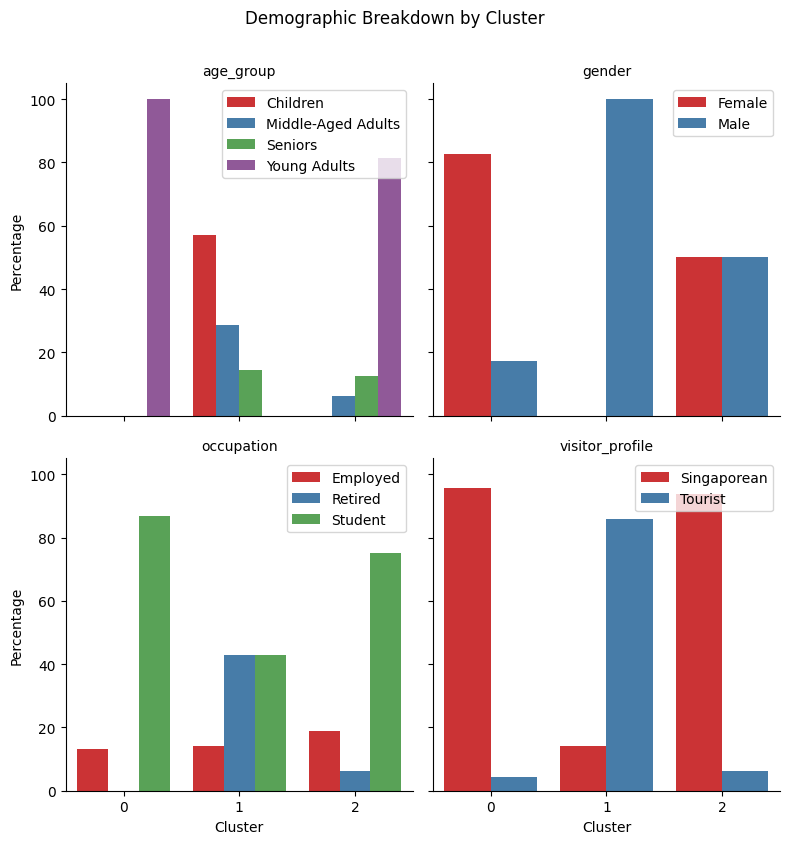

In [20]:
# Cross-Tabulation of Demographics by Cluster
demographic_summary = {}
for feature in demographic_features:
    crosstab = pd.crosstab(survey_data['Cluster'], survey_data[feature], normalize='index') * 100
    demographic_summary[feature] = crosstab

# Define a function to print cross-tabulation in a cleaner format
def print_crosstab_summary(summary_dict, title="Demographic"):
    for feature, crosstab in summary_dict.items():
        # Display the feature name
        print(f"\n### Proportion of {title} Feature: {feature.replace('_', ' ').title()} by Cluster\n")
        # Round values for better readability
        display(crosstab.round(2))

# Print formatted demographic tables
print_crosstab_summary(demographic_summary, title="Demographic")

# Visualization
base_palette = sns.color_palette("Set1", n_colors=9) 

# Convert demographic_summary to a DataFrame for FacetGrid plotting
demographic_summary_df = pd.concat(
    [df.reset_index().melt(id_vars='Cluster', var_name='Demographic', value_name='Percentage') 
     for demographic, df in demographic_summary.items()],
    keys=demographic_summary.keys()
).reset_index(level=0).rename(columns={'level_0': 'Feature'})

# Create a FacetGrid for a 2x2 layout with separate legends
g = sns.FacetGrid(demographic_summary_df, col='Feature', col_wrap=2, height=4, sharey=True)

# Function to dynamically select colors based on the unique values for each demographic feature
def barplot_with_custom_palette(data, **kwargs):
    unique_demographics = data['Demographic'].nunique()
    custom_palette = base_palette[:unique_demographics]
    sns.barplot(x='Cluster', y='Percentage', hue='Demographic', data=data, dodge=True, palette=custom_palette, **kwargs)

# Map barplot to each FacetGrid and add separate legends for each plot
g.map_dataframe(barplot_with_custom_palette)
for ax in g.axes.flat:
    ax.legend(loc='upper right', title='')

# Adjust plot aesthetics
g.set_axis_labels("Cluster", "Percentage")
g.set_titles("{col_name}")
g.fig.suptitle("Demographic Breakdown by Cluster", y=1.05)

plt.show()

### **Cluster Insights (Demographic Profiles)**

#### Demographic Breakdown by Cluster

#### Cluster 0 
- **Age Group**: 100% **Young Adults**
- **Gender**: Predominantly **Female** (82.6%)
- **Occupation**: Mostly **Students** (87%) with a few **Employed** (13%)
- **Visitor Profile**: Primarily **Singaporean** (95.7%)

#### Cluster 1 
- **Age Group**: 57.1% **Children**, 28.6% **Middle-Aged Adults**, 14.3% **Seniors**
- **Gender**: 100% **Male**
- **Occupation**: Balanced between **Students** (42.9%) and **Retired** (42.9%)
- **Visitor Profile**: Primarily **Tourists** (85.7%)

#### Cluster 2 
- **Age Group**: Primarily **Young Adults** (81.3%) with some **Seniors** (12.5%) and **Middle-Aged Adults** (6.3%)
- **Gender**: Equal split between **Female** and **Male** (50% each)
- **Occupation**: Mostly **Students** (75%), some **Employed** (18.8%), and a few **Retired** (6.3%)
- **Visitor Profile**: Mostly **Singaporean** (93.8%)

## **Behavioral Profiles of Each Cluster**

In [21]:
# Define behavioral-related features
behavioral_features = ['visitor_type', 'ticket_purchase_method', 'ticket_type', 'special_event_ticket']

### Statistical Validation¶

In [22]:
# Chi-Square Test for Association with Clusters
print("\nChi-Square Test Results for Behavioral Features:")
for feature in behavioral_features:
    contingency_table = pd.crosstab(survey_data['Cluster'], survey_data[feature])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"{feature}: Chi-Square = {chi2}, p-value = {p}")


Chi-Square Test Results for Behavioral Features:
visitor_type: Chi-Square = 27.416274350649346, p-value = 1.637530279444524e-05
ticket_purchase_method: Chi-Square = 5.270385864135863, p-value = 0.5096308892858952
ticket_type: Chi-Square = 54.622767857142854, p-value = 3.8974249938726783e-11
special_event_ticket: Chi-Square = 0.9329978171234541, p-value = 0.6271942933741389


### Chi-Square Test Results
- **Significant Associations**:
  - **Visitor Type** (`p = 1.64e-5`) and **Ticket Type** (`p = 3.90e-11`) are strongly associated with clusters, indicating distinct behavior patterns in visit type and ticket preference across segments.
- **No Significant Associations**:
  - **Ticket Purchase Method** (`p = 0.51`) and **Special Event Ticket** (`p = 0.63`) are not significantly associated with clusters, suggesting these factors are less defining.


Proportion of Visitor Type by Cluster



visitor_type,Family,Group,Solo
Cluster,,,
0,6.52,91.30,2.17
1,85.71,14.29,0.00
2,18.75,75.00,6.25



Proportion of Ticket Purchase Method by Cluster



ticket_purchase_method,Others,Physically at the entrance,Resort World Sentosa Website,"Third Party Vendor (e.g. Klook, Trip.com)"
Cluster,,,,
0,4.35,8.70,43.48,43.48
1,0.00,28.57,28.57,42.86
2,0.00,12.50,25.00,62.50



Proportion of Ticket Type by Cluster



ticket_type,One-day regular ticket,Regular ticket with Express Pass,VIP Experience
Cluster,,,
0,97.83,2.17,0.00
1,0.00,57.14,42.86
2,93.75,6.25,0.00



Proportion of Special Event Ticket by Cluster



special_event_ticket,No,Yes
Cluster,,
0,54.35,45.65
1,71.43,28.57
2,50.00,50.00


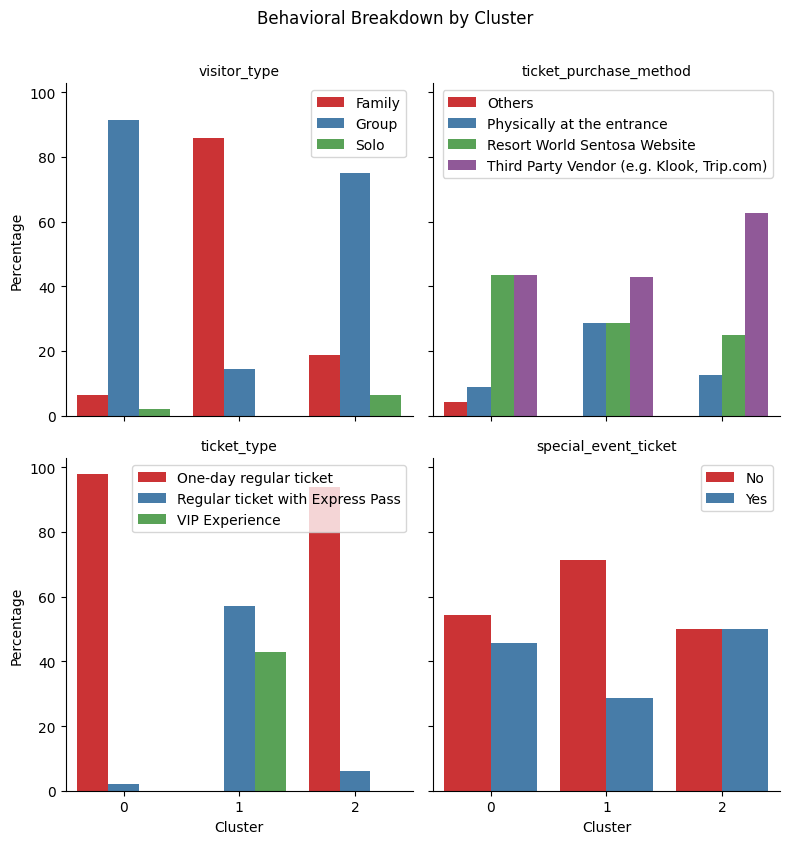

In [23]:
# Define a function to print cross-tabulation in a cleaner format
def print_crosstab_summary(summary_dict):
    for feature, crosstab in summary_dict.items():
        # Display the feature name
        print(f"\nProportion of {feature.replace('_', ' ').title()} by Cluster\n")
        # Round values for better readability
        display(crosstab.round(2))
        
# Cross-Tabulation of Behavioral Features by Cluster
behavioral_summary = {}
for feature in behavioral_features:
    crosstab = pd.crosstab(survey_data['Cluster'], survey_data[feature], normalize='index') * 100
    behavioral_summary[feature] = crosstab

print_crosstab_summary(behavioral_summary)

# Visualisation
behavioral_summary_df = pd.DataFrame()

for feature, crosstab in behavioral_summary.items():
    crosstab = crosstab.reset_index().melt(id_vars='Cluster', var_name='Behavior', value_name='Percentage')
    crosstab['Feature'] = feature  # Add feature column
    behavioral_summary_df = pd.concat([behavioral_summary_df, crosstab], ignore_index=True)

# Visualisation
base_palette = sns.color_palette("Set1", n_colors=9)

# Create a FacetGrid for a 2x2 layout with separate legends
g = sns.FacetGrid(behavioral_summary_df, col='Feature', col_wrap=2, height=4, sharey=True)

# Function to dynamically select colors based on the unique values for each feature
def barplot_with_custom_palette(data, **kwargs):
    unique_behaviors = data['Behavior'].nunique()
    custom_palette = base_palette[:unique_behaviors]
    sns.barplot(x='Cluster', y='Percentage', hue='Behavior', data=data, dodge=True, palette=custom_palette, **kwargs)

# Map barplot to each FacetGrid and add separate legends for each plot
g.map_dataframe(barplot_with_custom_palette)
for ax in g.axes.flat:
    ax.legend(loc='upper right', title='')

# Adjust plot aesthetics
g.set_axis_labels("Cluster", "Percentage")
g.set_titles("{col_name}")
g.fig.suptitle("Behavioral Breakdown by Cluster", y=1.05)

plt.show()

### **Cluster Insights (Behavioral Profiles)**

#### Behavioral Breakdown by Cluster

#### Cluster 0 
- **Visitor Type**: Primarily **Group visitors** (91.3%), with a few **Family visitors** (6.5%) and minimal **Solo visitors** (2.2%).
- **Ticket Purchase Method**: Mostly through **Resort World Sentosa Website** (43.5%) and **Third-Party Vendors** (43.5%), with a small portion buying **Physically at the entrance** (8.7%).
- **Ticket Type**: Predominantly **One-day regular tickets** (97.8%).
- **Special Event Ticket**: 45.7% purchased a special event ticket.

#### Cluster 1 
- **Visitor Type**: Predominantly **Family visitors** (85.7%), with some **Group visitors** (14.3%).
- **Ticket Purchase Method**: Primarily **Third-Party Vendors** (42.9%) and **Physically at the entrance** (28.6%).
- **Ticket Type**: High percentage of **Express Pass** (57.1%) and **VIP Experience** (42.9%).
- **Special Event Ticket**: Only 28.6% purchased a special event ticket.

#### Cluster 2 
- **Visitor Type**: Mostly **Group visitors** (75%) with some **Family** (18.8%) and **Solo** (6.3%) visitors.
- **Ticket Purchase Method**: Majority use **Third-Party Vendors** (62.5%), followed by **Resort World Sentosa Website** (25%) and **Physically at the entrance** (12.5%).
- **Ticket Type**: Primarily **One-day regular tickets** (93.8%).
- **Special Event Ticket**: 50% purchased a special event ticket.